In [186]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, random_split

# Summary-like from Tensorflow
from torchsummary import summary

# Import Numpy
import numpy as np
# Plot Import
import matplotlib.pyplot as plt
# For timer
import time
# Import OS
import os
# import local libs
import ecg_tools_lite as et

from statistics import mean

# WFDB
import wfdb

if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')

In [2]:
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu')

print("Device:", device, time.localtime().tm_mon, "/", time.localtime().tm_mday, "/", time.localtime().tm_year)
device

Device: cuda 11 / 28 / 2020


device(type='cuda')

In [191]:
ecg_whole = et.load_signal('118e06', '', v_fields=True, channel=1) # Creates an array of the entire thing
ecg_whole = torch.from_numpy(ecg_whole).double().to(device)
ecg_loader = DataLoader( ecg_whole, batch_size=360, shuffle=True)

Printing fields information of the signal: 
{'fs': 360, 'sig_len': 650000, 'n_sig': 1, 'base_date': None, 'base_time': None, 'units': ['mV'], 'sig_name': ['V1'], 'comments': ["Created by `nst' from records 118 and em (SNR = 6 dB)"]}


In [27]:
ecg_clean = et.load_ecg_file('all_chunks_fs1024_e24.npy')
ecg_noisy = et.load_ecg_file('all_chunks_fs1024_e06.npy')

In [28]:
start_array_pos = 0
end_array_pos = 1000

# add double().to(device) to move the data to GPU
noise_set = torch.from_numpy(ecg_noisy).double().to(device)
clean_set = torch.from_numpy(ecg_clean).double().to(device)

# Combined dataset of noise + clean on a single dataset will be used with enumerate
combined_dataset = torch.utils.data.TensorDataset( noise_set, clean_set) # CPU version
trainloader = DataLoader( combined_dataset, batch_size=1024, shuffle=True)

In [29]:
# kernel_size = (16,)
# padding_size= int( kernel_size[0]/2 ) # If odd, add -1

# class ae_sampler(nn.Module):
#     def __init__(self):
#         super(ae_sampler, self).__init__()

#         self.encoder = nn.Sequential(
#             nn.Conv1d(1024, 40, kernel_size, stride=2, padding=padding_size),
#             nn.ELU(True),   
#             nn.Conv1d(40, 20, kernel_size, stride=2, padding=padding_size),
#             nn.ELU(True),   
#             nn.Conv1d(20, 20, kernel_size, stride=2, padding=padding_size),
#             nn.ELU(True),
#             # nn.Conv1d(20, 20, kernel_size, stride=2, padding=padding_size),
#             # nn.ELU(True),   
#             # nn.Conv1d(20, 40, kernel_size, stride=2, padding=padding_size),
#             # nn.ELU(True),   
#             # nn.Conv1d(40, 1, kernel_size, stride=1, padding=padding_size),
#             # nn.ELU(True),   
#         )

#         self.decoder = nn.Sequential(
#             # nn.ConvTranspose1d(1, 40, kernel_size, stride=1),
#             # nn.ConvTranspose1d(40, 20, kernel_size, stride=2),
#             # nn.ConvTranspose1d(20, 20, kernel_size, stride=2),
#             # nn.ConvTranspose1d(20, 20, kernel_size, stride=2),
#             # nn.ConvTranspose1d(20, 40, kernel_size, stride=2),
#             nn.ConvTranspose1d(40, 1024, kernel_size, stride=2),
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)

#         return x

In [30]:
# def train_model(model, trainloader, epochs):
#     elapsed_start = time.time()
#     train_loss = []
#     criterion = nn.MSELoss().cuda()
#     optimizer = torch.optim.Adam( model.parameters(), lr=1e-3 )
    
#     for epoch in range(epochs):
#         # Running loss computed at the end
#         running_loss = 0.0        
#         # start timer
#         epoch_start = time.time()
#         # Loop through the entire dataset
#         for i, (noise_sig, clean_sig) in enumerate(trainloader):
            
#             optimizer.zero_grad()
            
#             x_prime = model( noise_sig )
            
#             loss = criterion( x_prime, clean_sig) # or loss function
            
#             # Backpropagation
#             loss.backward()
            
#             optimizer.step()
#             running_loss += loss.item()
        
#             loss = running_loss / len(trainloader)
        
#             train_loss.append(loss)

#         # ===== Epoch timer =====
#         epoch_end = time.time()
#         time_total = epoch_end - epoch_start
#         print( f"Epoch {epoch+1} of 2 || time: {time_total:.2f} || loss = {loss}")
#         # ===== Total training elapsed time =====
#     elapsed_end = time.time()
#     elapsed_total = elapsed_end-elapsed_start
#     elapsed_mins = int(elapsed_total/60)
#     elapsed_secs = int(elapsed_total - (60 * elapsed_mins))
#     print(f'Elapsed time: {elapsed_total:.2f}, (in mins: {elapsed_mins}:{elapsed_secs})')

#     return train_loss

In [83]:
def train_model(model, trainloader, epochs):
    elapsed_start = time.time()
    train_loss = []
    criterion = nn.MSELoss().cuda()
    optimizer = torch.optim.Adam( model.parameters(), lr=1e-3 )
    
    for epoch in range(epochs):
        # Running loss computed at the end
        running_loss = 0.0        
        # start timer
        epoch_start = time.time()
        # Loop through the entire dataset
        for i, noise_sig in enumerate(trainloader):
            
            optimizer.zero_grad()
            # one_sig = noise_sig
            one_sig = noise_sig.view( noise_sig.shape[1], noise_sig.shape[0], 1)
            x_prime = model( one_sig )
            
            loss = criterion( x_prime, one_sig) # or loss function
            
            # Backpropagation
            loss.backward()
            
            optimizer.step()
            running_loss += loss.item()
        
            loss = running_loss / len(trainloader)
        
            train_loss.append(loss)

        # ===== Epoch timer =====
        epoch_end = time.time()
        time_total = epoch_end - epoch_start
        print( f"Epoch {epoch+1} of 2 || time: {time_total:.2f} || loss = {loss}")
        # ===== Total training elapsed time =====
    elapsed_end = time.time()
    elapsed_total = elapsed_end-elapsed_start
    elapsed_mins = int(elapsed_total/60)
    elapsed_secs = int(elapsed_total - (60 * elapsed_mins))
    print(f'Elapsed time: {elapsed_total:.2f}, (in mins: {elapsed_mins}:{elapsed_secs})')

    return train_loss

In [86]:
kernel_size = 16
padding_size= int( kernel_size/2 ) # If odd, add -1

class ae_sampler(nn.Module):
    def __init__(self):
        super(ae_sampler, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(1024, 40, kernel_size, stride=2, padding=padding_size),
            nn.BatchNorm1d(40),
            nn.ELU(True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(40, 1, kernel_size, stride=2),
        )

    def forward(self, x):
        print( x.shape )
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [91]:
model = ae_sampler().cuda()
model.double()
losses = train_model( model, ecg_loader, 2)
# train_model( ae_sampler, noiseloader, 1)

torch.Size([1, 1024, 1])


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 40, 1])

In [45]:
# x = model.encoder( ecg_whole )
# x = model.decoder( x )
# x = x.cpu()
# x = x.detach().numpy()

RuntimeError: Expected 3-dimensional input for 3-dimensional weight [40, 1, 16], but got 2-dimensional input of size [650000, 1] instead

In [36]:
# x = model.encoder(noise_set)
# x = model.decoder(x)
# x = x.cpu()
# x = x.detach().numpy()

In [42]:
summary(model)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv1d: 2-1                       680
|    └─ELU: 2-2                          --
├─Sequential: 1-2                        --
|    └─ConvTranspose1d: 2-3              641
Total params: 1,321
Trainable params: 1,321
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv1d: 2-1                       680
|    └─ELU: 2-2                          --
├─Sequential: 1-2                        --
|    └─ConvTranspose1d: 2-3              641
Total params: 1,321
Trainable params: 1,321
Non-trainable params: 0

In [20]:
index_chk = 0
clean_set_cpu = clean_set.cpu()
if x.shape[2] == 1:
    plt.figure(figsize=(20,5))
    plt.plot( clean_set_cpu[index_chk], c='green' )
    plt.plot( x[index_chk], c='red' )
else:
    print(f"Shape is too large -> {x.shape}")
    

Shape is too large -> (5842, 1024, 16)


In [21]:
# def convert_sig_to_numpy(input_sig):
#     temp_sig = input_sig
#     temp_sig = temp_sig.view( temp_sig.shape[1], 1)
#     temp_sig = temp_sig.cpu()
#     temp_sig = temp_sig.detach().numpy()
#     return temp_sig

# for i, (noise_sig, clean_sig) in enumerate(trainloader):
#     temp_sig_noise = convert_sig_to_numpy(noise_sig)
#     temp_sig_clean = convert_sig_to_numpy(clean_sig)

#     plt.figure(figsize=(20,5))
#     plt.plot( temp_sig_clean )
#     plt.plot( temp_sig_noise )
#     if i == 1:
#         break

In [ ]:
DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None, *, prefetch_factor=2,
           persistent_workers=False)

In [183]:
ecg_sampler = torch.utils.data.Sampler( ecg_whole )

In [201]:
train_size = int( (ecg_whole.shape[0])*.80 ) # Get 80%
val_size = int( (ecg_whole.shape[0])*.20 ) # Get 20%
train_dataset, val_dataset = random_split( ecg_whole, (train_size, val_size) ) # (dataset, (80%, 20% of data ))

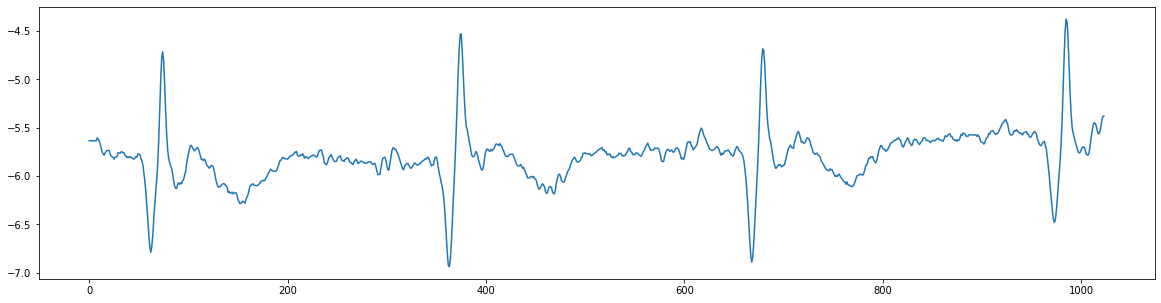

In [181]:


ecg_loader2 = DataLoader( ecg_whole, batch_size=1024)

for i, data in enumerate(ecg_loader2):
    if i == 0:
        x = data
        x = x.cpu().numpy()
        plt.figure( figsize=(20,5) )
        plt.plot(x)
        break